# Graph exploration

In [62]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib
import networkx as nx

Data_path = 'Data/'

Load the movie and Oscars data and extract the attributes

In [2]:
movie_df = pd.read_csv(Data_path+'tmdb_5000_movies.csv', parse_dates=['release_date'])
# create a columns with the year of the coresponding Oscar ceremony for merging latter on
movie_df['ceremony_year'] = movie_df['release_date'].apply(lambda date: date.year+1).fillna(0).astype(int)

In [3]:
oscar_df = pd.read_csv(Data_path+'oscars_website.csv')

Merge the two dataframe and get the nodes attribute dataframe 

In [4]:
# merge on both title and ceremony_year to differentiate two Titanics movies or two King knog movies from different years
df = pd.merge(movie_df, oscar_df, how='left', left_on=['ceremony_year', 'title'], right_on=['Year', 'Films'])
df[['Oscars','Nominations']] = df[['Oscars','Nominations']].fillna(0)

In [5]:
nodes_attributes_df = df[['id', 'title', 'budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count', 'ceremony_year', 'Oscars', 'Nominations']]
nodes_attributes_df.head()

,id,title,budget,popularity,revenue,runtime,vote_average,vote_count,ceremony_year,Oscars,Nominations
0,19995,Avatar,237000000,150.437577,2787965087,162.0,7.2,11800,2010,3.0,9.0
1,285,Pirates of the Caribbean: At World's End,300000000,139.082615,961000000,169.0,6.9,4500,2008,0.0,2.0
2,206647,Spectre,245000000,107.376788,880674609,148.0,6.3,4466,2016,1.0,1.0
3,49026,The Dark Knight Rises,250000000,112.312950,1084939099,165.0,7.6,9106,2013,0.0,0.0
4,49529,John Carter,260000000,43.926995,284139100,132.0,6.1,2124,2013,0.0,0.0


Load the Adjacency matrix

In [6]:
with open(Data_path+'Adjacency_matrix.pickle', 'rb') as src:
    A = pickle.load(src)
    print(f'>>> Loading Adjacency matrix matrix with shape {A.shape}')

>>> Loading Adjacency matrix matrix with shape (4803, 4803)


In [7]:
# checking that there is the good amount of rows (should equals number of node)
print(f'There are {A.shape[0]} nodes and {nodes_attributes_df.shape[0]} attributes rows.')

There are 4803 nodes and 4803 attributes rows.


Build a networkX graph from the adjacency matrix

In [8]:
def graph_summary(G):
    """
    Display properties of the given nx.Graph
    ------
    Input 
        |---- G : nx.Graph
    Output 
        |---- None
    """
    n_edges = G.number_of_edges()
    n_nodes = G.number_of_nodes()
    n_connect_comp = nx.number_connected_components(G)
    avg_degree = 2*n_edges/n_nodes
    avg_cluster_coef = nx.average_clustering(G)

    print(f'>>> Network summary : \n', \
          f'--> {n_edges} edges\n', \
          f'--> {n_nodes} nodes\n', \
          f'--> average degree : {avg_degree:.0f}\n', \
          f'--> connected compoenent : {n_connect_comp}\n', \
          f'--> average clustering coeeficient : {avg_cluster_coef:.3f}')

In [10]:
G=nx.from_numpy_matrix(A)
graph_summary(G)

>>> Network summary : 
 --> 43126 edges
 --> 4803 nodes
 --> average degree : 18
 --> connected compoenent : 490
 --> average clustering coeeficient : 0.302


Add the node attributes

In [11]:
nx.set_node_attributes(G, dict(nodes_attributes_df.transpose()))

Get the largest component and display it. 

In [14]:
G_large = max(nx.connected_component_subgraphs(G), key=len)
graph_summary(G_large)

>>> Network summary : 
 --> 43080 edges
 --> 4270 nodes
 --> average degree : 20
 --> connected compoenent : 1
 --> average clustering coeeficient : 0.339


Plot the visual summary for the graph

In [209]:
def get_graph_properties(G):
    """ return the graph parameters in string to be plotted in a table """
    n_edges = G.number_of_edges()
    n_nodes = G.number_of_nodes()
    n_cc = nx.number_connected_components(G)
    GC_size = max(nx.connected_component_subgraphs(G), key=len).number_of_nodes()
    avg_degree = 2*n_edges/n_nodes
    avg_cluster_coef = nx.average_clustering(G)
    
    labels =np.array( ['N edges', 'N nodes', 'N connected\ncomponents', 'Giant Comp. \nsize', 'avg degree', 'avg clustering\ncoefficient'])
    data =  np.array([f'{n_edges:.0f}', f'{n_nodes:.0f}', f'{n_cc:.0f}', f'{GC_size:.0f}', f'{avg_degree:.3f}', f'{avg_cluster_coef :.3f}'])
    return data, labels

In [215]:
# The network to display
the_graph = G_large
network_name = 'Giant Component'
pos=nx.spring_layout(the_graph)

In [217]:
# compute graph info for table
data_whole, labels = get_graph_properties(G)
data_sub, _ = get_graph_properties(the_graph)
data = np.stack([data_whole, data_sub], axis=1)

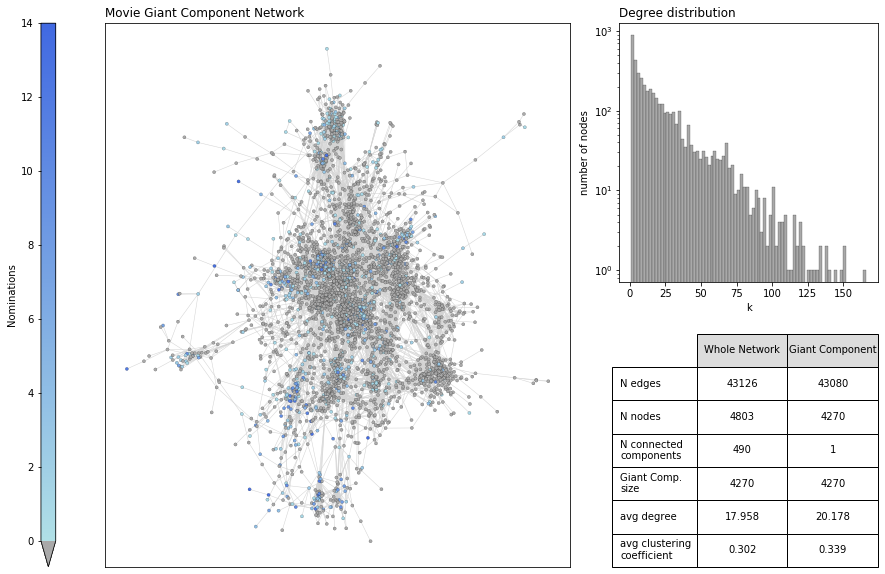

In [220]:
fig = plt.figure(figsize=(15,10))
gs = plt.GridSpec(2, 3, wspace=0.2, hspace=0.1, width_ratios=[0.02, 0.63, 0.35], height_ratios=[0.5, 0.5])
title_fs = 12

# Network visualization
atr = 'Nominations'
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('node_cmap', ['powderblue', 'royalblue'])
cmap.set_under(color='darkgray')
ax_net = fig.add_subplot(gs[:,1])
nx.draw_networkx(the_graph, pos, ax=ax_net, \
                                with_labels=False, \
                                node_size=10, \
                                node_color =  list(nx.get_node_attributes(the_graph, atr).values()),\
                                vmin=0.01, cmap=cmap, \
                                alpha=1, \
                                linewidths=0.15, \
                                width=0.5, \
                                edge_color='lightgray')
ax_net.collections[0].set_edgecolor("#000000") 
ax_net.set_title('Movie Giant Component Network', loc='left', fontsize=title_fs)

# colorbar
color_ax = fig.add_subplot(gs[:,0])
nrm = matplotlib.colors.Normalize(vmin=nodes_attributes_df[atr].min(), vmax=nodes_attributes_df[atr].max())
fig.colorbar(matplotlib.cm.ScalarMappable(norm=nrm, cmap=cmap),\
                    cax=color_ax, extend='min')
color_ax.yaxis.set_ticks_position('left')
color_ax.yaxis.set_label_position('left')
color_ax.set_ylabel(atr)

# degree distribution 
ax_deg = fig.add_subplot(gs[0,2])
degrees = dict(the_graph.degree()).values()

ax_deg.hist(degrees, color='darkgray', bins=80, linewidth=0.2, edgecolor='black', log=True)
ax_deg.set_title('Degree distribution', loc='left', fontsize=title_fs)
ax_deg.set_xlabel('k')
ax_deg.set_ylabel('number of nodes')

# table info
ax_table = fig.add_subplot(gs[1,2])
ax_table.set_axis_off()
table = ax_table.table(cellText=data, rowLabels=labels, cellLoc='center', \
                                     colColours=['gainsboro'] * len(labels), colLabels=['Whole Network', network_name], loc='center', \
                                     bbox=[0.3, 0, 0.7, 0.9])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1,1)

fig.savefig('Figures/network_summary.png', dpi=200, bbox_inches='tight')
plt.show()